In [1]:
import h5py as h5
import numpy as np
from math import ceil, floor, isnan
import random
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import gc
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices[0])

tf.random.set_seed(1234)

2.1.0
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
filenames = {
    "herwig": "GAN-data\events_anomalydetection_DelphesHerwig_qcd_features.h5",
    "pythiabg": "GAN-data\events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "GAN-data\events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]
features = ["px", "py", "pz", "m", "tau1", "tau2", "tau3"]

train_features = ["tau21j1"] # Can be flexibly changed to suit GAN needs

In [3]:
def load_data(datatype, stop = None):
    input_frame = pd.read_hdf(filenames[datatype], stop = stop)
    output_frame = input_frame.copy()
    for feature in features:
        output_frame[feature + "j1"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j1"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j2"]
        output_frame[feature + "j2"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j2"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j1"]
    del input_frame
    gc.collect()
    output_frame["mjdelta"] = output_frame["mj1"] - output_frame["mj2"]
    output_frame["ej1"] = np.sqrt(output_frame["mj1"]**2 + output_frame["pxj1"]**2 + output_frame["pyj1"]**2 + output_frame["pzj1"]**2)
    output_frame["ej2"] = np.sqrt(output_frame["mj2"]**2 + output_frame["pxj2"]**2 + output_frame["pyj2"]**2 + output_frame["pzj2"]**2)
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt((output_frame["pxj1"] + output_frame["pxj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2 + (output_frame["pzj1"] + output_frame["pzj2"])**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)
    output_frame["tau21j1"] = output_frame["tau2j1"] / output_frame["tau1j1"]
    output_frame["tau32j1"] = output_frame["tau3j1"] / output_frame["tau2j1"]
    output_frame["tau21j2"] = output_frame["tau2j2"] / output_frame["tau1j2"]
    output_frame["tau32j2"] = output_frame["tau3j2"] / output_frame["tau2j2"]
    return output_frame

In [4]:
# Network hyperparameters
BATCH_SIZE = 256
EPOCHS = 500 # 1000 epochs takes >~ 3 hours on GTX 1660
BINS = 25

# Adam hyperparameters as recommended by arXiv:1704.00028
LEARNING_RATE = 1e-4
BETA_1 = 0
BETA_2 = 0.9

# WGAN hyperparameters
N_CRITIC = 5
C_LAMBDA = 10

In [5]:
df = load_data("herwig")

In [6]:
# Ensures all batches have same size

df.dropna(inplace = True)
df.drop([i for i in range(df.shape[0] % (BATCH_SIZE * 4))], inplace = True)
df.reset_index(drop = True, inplace = True)
df = df.astype('float32')

In [7]:
df_reduced = df[train_features]
del df
gc.collect()

57

In [8]:
np_reduced = np.array(df_reduced)

In [9]:
est = KBinsDiscretizer(n_bins = BINS, encode = "onehot-dense", strategy = "uniform")
np_transformed = est.fit_transform(np_reduced).astype("float32")
print("Bin edges:")
print(est.bin_edges_)

Bin edges:
[array([0.01555741, 0.05408376, 0.09261011, 0.13113646, 0.16966281,
       0.20818916, 0.24671551, 0.28524186, 0.3237682 , 0.36229455,
       0.4008209 , 0.43934725, 0.4778736 , 0.51639995, 0.5549263 ,
       0.59345265, 0.631979  , 0.67050534, 0.70903169, 0.74755804,
       0.78608439, 0.82461074, 0.86313709, 0.90166344, 0.94018979,
       0.97871614])]


In [10]:
X_train, X_test = train_test_split(np_transformed, test_size = 0.25, random_state = 1234)
len_dataset = int(X_train.shape[0] / BATCH_SIZE)
len_testset = int(X_test.shape[0] / BATCH_SIZE)
print("Dataset consists of {} batches of {} samples each, total {} samples".format(len_dataset, BATCH_SIZE, len_dataset * BATCH_SIZE))
print("Testset consists of {} batches of {} samples each, total {} samples".format(len_testset, BATCH_SIZE, len_testset * BATCH_SIZE))

Dataset consists of 2928 batches of 256 samples each, total 749568 samples
Testset consists of 976 batches of 256 samples each, total 249856 samples


In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_test)).batch(BATCH_SIZE)

In [12]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(BINS,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(50))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(BINS, activation='softmax'))
    assert model.output_shape == (None, BINS)

    return model

In [13]:
generator = make_generator_model()

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(BINS,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1)) # WGAN: No sigmoid activation in last layer

    return model

In [15]:
discriminator = make_discriminator_model()

In [16]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                1300      
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0

In [17]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                1300      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [18]:
@tf.function
def gradient_penalty(real, fake, epsilon): 
    # mixed_images = real * epsilon + fake * (1 - epsilon)
    mixed_images = fake + epsilon * (real - fake)
    with tf.GradientTape() as tape:
        tape.watch(mixed_images) 
        mixed_scores = discriminator(mixed_images)
        
    gradient = tape.gradient(mixed_scores, mixed_images)[0]
    
    gradient_norm = tf.norm(gradient)
    penalty = tf.math.reduce_mean((gradient_norm - 1)**2)
    return penalty

In [19]:
@tf.function
def discriminator_loss(real_output, fake_output, gradient_penalty):
    loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + C_LAMBDA * gradient_penalty
    return loss

In [20]:
@tf.function
def generator_loss(fake_output):
    gen_loss = -1. * tf.math.reduce_mean(fake_output)
    return gen_loss

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)

In [22]:
# Convert tensor to float for loss function plotting
def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]

In [23]:
@tf.function
def train_step_generator():
  noise = tf.random.normal([BATCH_SIZE, BINS])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  return gen_loss

In [24]:
@tf.function
def train_step_discriminator(images):
  noise = tf.random.normal([BATCH_SIZE, BINS])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    epsilon = tf.random.normal([BATCH_SIZE, BINS])
    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  return disc_loss

In [25]:
@tf.function
def evaluate_generator():
    noise = tf.random.normal([BATCH_SIZE, BINS])
    generated_images = generator(noise, training=False)

    fake_output = discriminator(generated_images, training=False)

    gen_loss = generator_loss(fake_output)

    return gen_loss

In [26]:
@tf.function
def evaluate_discriminator(images):
    noise = tf.random.normal([BATCH_SIZE, BINS])
    generated_images = generator(noise, training=False)

    real_output = discriminator(images, training=False)
    fake_output = discriminator(generated_images, training=False)

    epsilon = tf.random.normal([BATCH_SIZE, BINS])
    gp = gradient_penalty(images, generated_images, epsilon)
    
    disc_loss = discriminator_loss(real_output, fake_output, gp)

    return disc_loss

In [27]:
np.reshape(est.inverse_transform(X_train), -1)

array([0.38155773, 0.80534757, 0.57418947, ..., 0.84387391, 0.80534757,
       0.38155773])

In [28]:
def softmax_to_onehot(softmax):
    temp = np.expand_dims(np.argmax(softmax, axis = 1), axis = 1)
    temp2 = np.zeros(softmax.shape)
    np.put_along_axis(temp2, temp, 1, axis = 1)
    return temp2

In [29]:
def graph_gan(generator):
    realdata = np.reshape(est.inverse_transform(X_train), -1)
    fakedata = np.reshape(est.inverse_transform(softmax_to_onehot(generator(tf.random.normal((10000, BINS)), training=False))), -1)

    plt.title("N-subjettiness ratio")
    plt.ylabel("Normalized to Unity")
    plt.xlabel("$\\tau_{21J_1}$")
    plt.hist(realdata, bins = BINS, range = (est.bin_edges_[0][0], est.bin_edges_[0][-1]), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)
    plt.hist(fakedata, bins = BINS, range = (est.bin_edges_[0][0], est.bin_edges_[0][-1]), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.legend()
    plt.show()

In [30]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

In [31]:
def graph_genloss():
    plt.title("Generator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_gen_losses, 'b', label = "Training loss")
    plt.plot(test_gen_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [32]:
def graph_discloss():
    plt.title("Discriminator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_disc_losses, 'b', label = "Training loss")
    plt.plot(test_disc_losses, 'r', label = "Validation loss")
    plt.legend()
    plt.show()

In [33]:
def train(dataset, testset, epochs, n_critic):
  for epoch in tqdm(range(epochs)):
    print_losses = False # ((epoch + 1) % 10 == 0)
    draw_outputs = ((epoch + 1) % 20 == 0)

    train_gen_loss = 0
    train_disc_loss = 0

    test_gen_loss = 0
    test_disc_loss = 0

    # Training

    for batchnum, image_batch in enumerate(dataset):
      if random.random() < 1 / n_critic:
        train_gen_loss += K_eval(train_step_generator()) / len_dataset * n_critic
      train_disc_loss += K_eval(train_step_discriminator(image_batch)) / len_dataset
    
    train_gen_losses.append(train_gen_loss)
    train_disc_losses.append(train_disc_loss)

    # Evaluation

    for batchnum, test_batch in enumerate(testset):
      test_gen_loss += K_eval(evaluate_generator()) / len_testset
      test_disc_loss += K_eval(evaluate_discriminator(test_batch)) / len_testset

    test_gen_losses.append(test_gen_loss)
    test_disc_losses.append(test_disc_loss)

    # Logging

    if print_losses:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      print()
      print("Generator training loss: " + str(train_gen_losses[-1]))
      print("Discriminator training loss: " + str(train_disc_losses[-1]))
      print()
      print("Generator validation loss: " + str(test_gen_losses[-1]))
      print("Discriminator validation loss: " + str(test_disc_losses[-1]))

    if draw_outputs:
      print()
      print("Epoch " + str(epoch + 1) + ":")
      graph_gan(generator)
      graph_genloss()
      graph_discloss()

  4%|▍         | 19/500 [04:41<1:53:42, 14.18s/it]
Epoch 20:


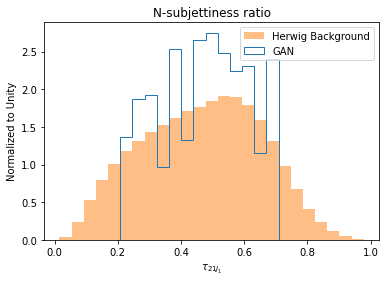

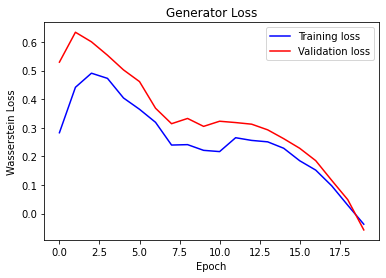

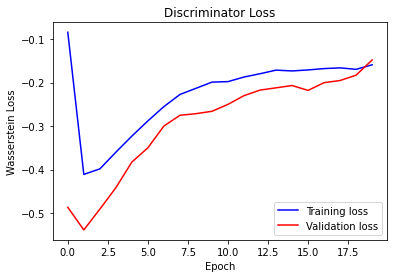

  8%|▊         | 39/500 [09:27<1:37:11, 12.65s/it]
Epoch 40:


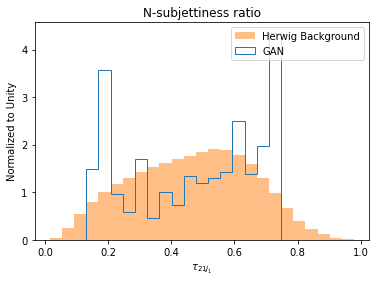

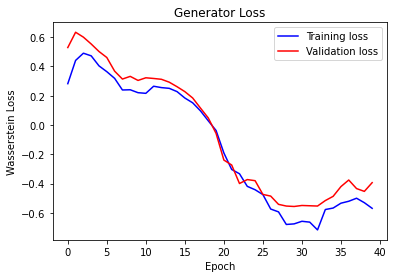

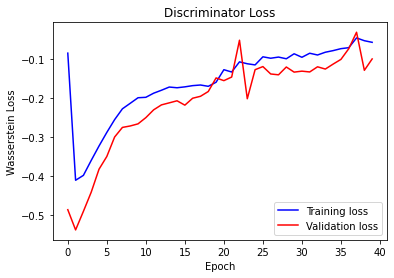

 12%|█▏        | 59/500 [13:28<1:27:55, 11.96s/it]
Epoch 60:


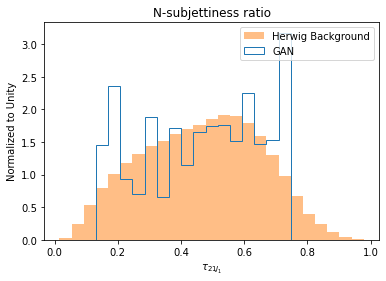

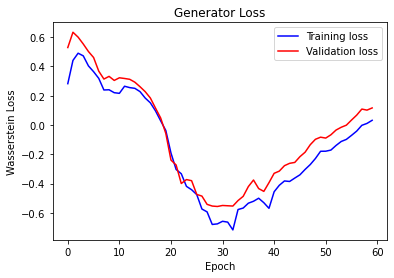

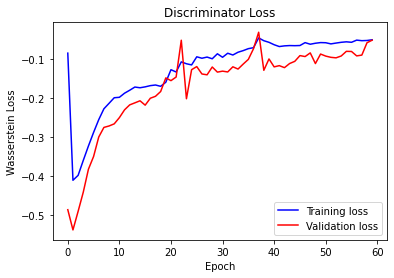

 13%|█▎        | 65/500 [14:52<1:39:30, 13.73s/it]


KeyboardInterrupt: 

In [34]:
train(train_dataset, test_dataset, EPOCHS, N_CRITIC)